# Задание 3. A/B тесты по метрике линеаризованных лайков

## Задачи

- Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?
- Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли 𝑝−𝑣𝑎𝑙𝑢𝑒 меньше?

# Загружаем библиотеки и подключаемся к базе

In [51]:
import hashlib
import pandahouse
import pandas as pd
import swifter
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import random
import numpy as np
pd.set_option('display.float_format', '{:.5f}'.format)
import warnings
warnings.filterwarnings('ignore')
sns.set(rc={'figure.figsize':(15,7)})

In [52]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

# Сравнение групп 0 и 3

In [53]:
q = '''SELECT user_id, exp_group, countIf(action='like') likes, countIf(action='view') views, countIf(action='like')/countIf(action='view') ctr
from simulator_20220620.feed_actions 
group by user_id, exp_group
having toDate(time)>='2022-05-24' and toDate(time)<='2022-05-30' and exp_group in (0,3) 
'''

In [54]:
df03 = pandahouse.read_clickhouse(query=q, connection=connection)
df0 = df03[df03['exp_group']==0]
df3 = df03[df03['exp_group']==3]

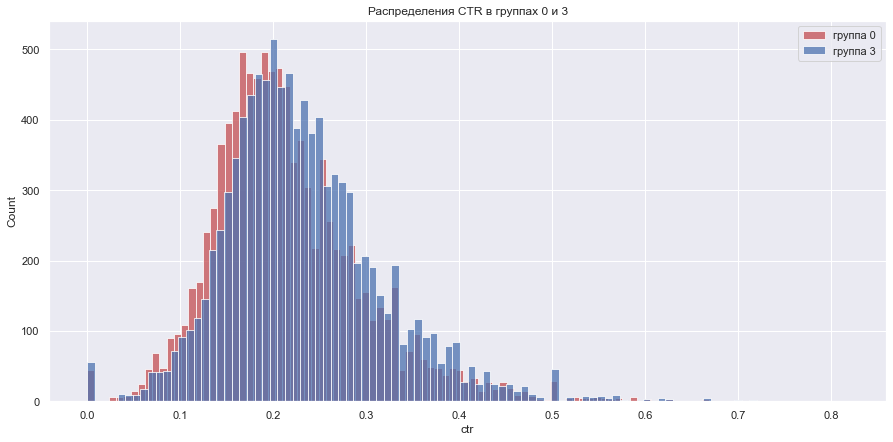

In [55]:
sns.histplot(df0.ctr, color='r', bins=100)
sns.histplot(df3.ctr, color='b', bins=100)
plt.title('Распределения CTR в группах 0 и 3')
plt.legend(['группа 0', 'группа 3'])

Распределения очень похожи и "на глаз", но визуально группа 0 немного сдвинута влево относительно группы 3. В обеих есть выбросы в районе 0 и 0,5. Посчитаем глобальный CTR и линеаризуем лайки.

In [56]:
# вроде бы контрольная это группа 0, насколько помню из лекции
global_ctr_0 = df0.likes.sum() / df0.views.sum()
# линеаризация
df0['linearised_likes'] = df0.likes - global_ctr_0*df0.views
df3['linearised_likes'] = df3.likes - global_ctr_0*df3.views

Рисуем распределения заново 

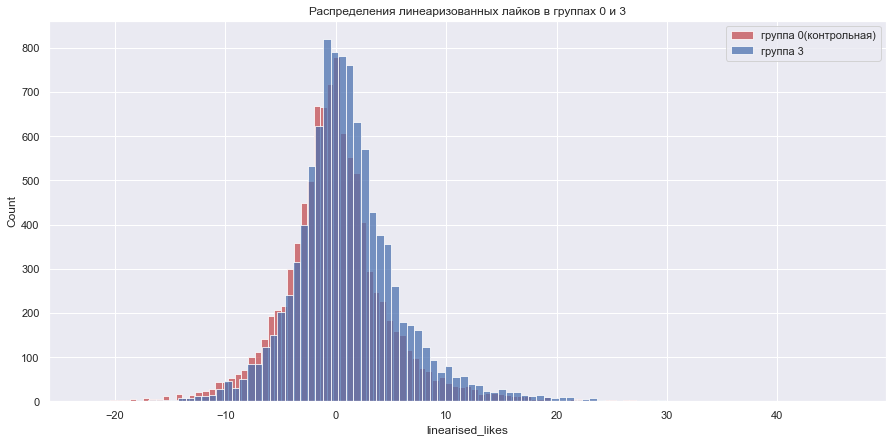

In [57]:
sns.histplot(df0.linearised_likes, color='r', bins=100)
sns.histplot(df3.linearised_likes, color='b', bins=100)
plt.title('Распределения линеаризованных лайков в группах 0 и 3')
plt.legend(['группа 0(контрольная)', 'группа 3'])

Теперь обе группы более сглажены, но смещение осталось. Смотрим т-тест

In [58]:
_, pvalue = stats.ttest_ind(df0.ctr, df3.ctr, equal_var=False)
_, pvalue_linear_likes = stats.ttest_ind(df0.linearised_likes, df3.linearised_likes, equal_var=False)
print(f'P-value t-теста для ctr = {pvalue}, для линеаризованных лайков = {pvalue_linear_likes}')

P-value t-теста для ctr = 1.055849414662529e-43, для линеаризованных лайков = 5.4914249479690016e-52


P-value уменьшился, тест покрасился для обоих случаев, то есть не подтверждается гипотеза о равенстве средних. В данном тесте линеаризация помогла уменьшить p-value, но тест и без линеариции прокрашивался. Посмотрим на тест Манна-Уитни

In [59]:
_, pvalue_mw = stats.mannwhitneyu(df0.ctr, df3.ctr)
_, pvalue_mw_sm = stats.mannwhitneyu(df0.linearised_likes, df3.linearised_likes)
print(f'P-value теста Манна-Уитни для ctr = {pvalue_mw}, для линеаризованных лайков = {pvalue_mw_sm}')

P-value теста Манна-Уитни для ctr = 1.1952055473582936e-57, для линеаризованных лайков = 1.1517315029786597e-63


P-value уменьшился, тест покрасился для обоих случаев, то есть не подтверждается гипотеза о равенстве средних. В данном тесте линеаризация также помогла уменьшить p-value, но тест и без линеариции прокрашивался.

##  Вывод
Для групп 0 и 3 p-value t-теста и теста Манна-Уитни сильно меньше 0,05 на обычном CTR, то есть гипотеза о равенстве средних не подтверждается. Для линеаризованных лайков гипотеза о равенстве средних также не подтвердилась, p-value стал меньше в обоих тестах.

# Сравнение групп 1 и 2

In [60]:
q = '''SELECT user_id, exp_group, countIf(action='like') likes, countIf(action='view') views, countIf(action='like')/countIf(action='view') ctr
from simulator_20220620.feed_actions 
group by user_id, exp_group
having toDate(time)>='2022-05-24' and toDate(time)<='2022-05-30' and exp_group in (1,2) 
'''

In [61]:
df12 = pandahouse.read_clickhouse(query=q, connection=connection)
df1 = df12[df12['exp_group']==1]
df2 = df12[df12['exp_group']==2]

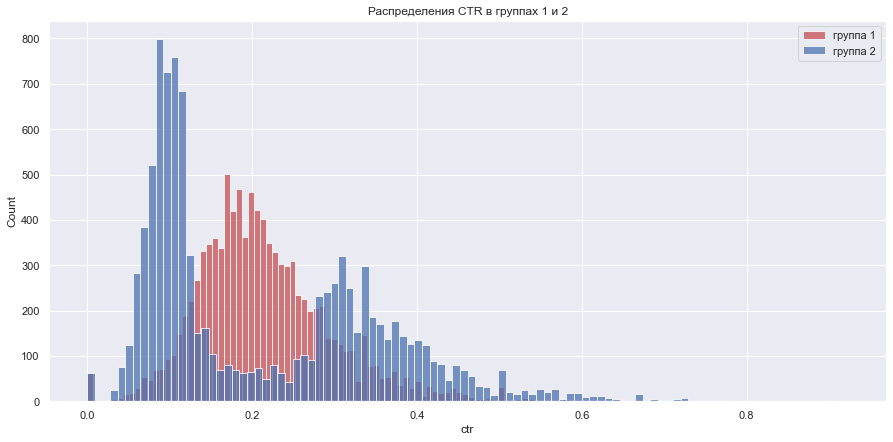

In [62]:
sns.histplot(df1.ctr, color='r', bins=100)
sns.histplot(df2.ctr, color='b', bins=100)
plt.title('Распределения CTR в группах 1 и 2')
plt.legend(['группа 1', 'группа 2'])

Так как контрольная группа 1, значит у тестовой выборки распределение CTR с двумя горбами, есть выбросы у нуля и 1 у обеих групп. Посчитаем глобальный CTR и линеаризуем лайки.

In [63]:
global_ctr_1 = df1.likes.sum() / df1.views.sum()
df1['linearised_likes'] = df1.likes - global_ctr_1*df1.views
df2['linearised_likes'] = df2.likes - global_ctr_1*df2.views

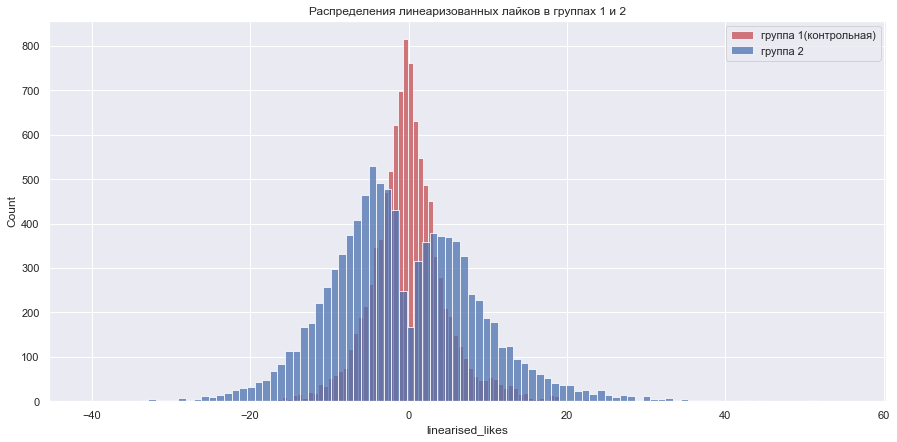

In [64]:
sns.histplot(df1.linearised_likes, color='r', bins=100)
sns.histplot(df2.linearised_likes, color='b', bins=100)
plt.title('Распределения линеаризованных лайков в группах 1 и 2')
plt.legend(['группа 1(контрольная)', 'группа 2'])

Горбы сохранились, но оба распределения стали более сглаженными и сместились к центре. Смотрим т-тест

In [65]:
_, pvalue = stats.ttest_ind(df1.ctr, df2.ctr, equal_var=False)
_, pvalue_linear_likes = stats.ttest_ind(df1.linearised_likes, df2.linearised_likes, equal_var=False)
print(f'P-value t-теста для ctr = {pvalue}, для линеаризованных лайков = {pvalue_linear_likes}')

P-value t-теста для ctr = 0.4780623130874935, для линеаризованных лайков = 9.439432187037712e-10


P-value t-теста для ctr было сильно больше 0,05, то есть подтверждалась гипотеза о равенстве средних. Для линеаризованных лайков гипотеза о равенстве средних не подтвердилась. Посмотрим на тест Манна-Уитни

In [66]:
_, pvalue_mw = stats.mannwhitneyu(df1.ctr, df2.ctr)
_, pvalue_mw_sm = stats.mannwhitneyu(df1.linearised_likes, df2.linearised_likes)
print(f'P-value теста Манна-Уитни для ctr = {pvalue_mw}, для линеаризованных лайков = {pvalue_mw_sm}')

P-value теста Манна-Уитни для ctr = 6.0376484617779035e-56, для линеаризованных лайков = 9.404319579641738e-27


P-value теста Манна-Уитни для ctr было сильно меньше 0,05, то есть не подтверждалась гипотеза о равенстве средних. Для линеаризованных лайков гипотеза о равенстве средних также не подтвердилась, но p-value вырос.

## Вывод
Для групп 1 и 2 p-value t-теста сильно больше 0,05, а для теста Манна-Уитни сильно меньше 0,05 на обычном CTR, то есть гипотеза о равенстве средних не подтверждается для теста Манна-Уитни и подтверждается для т-теста. Для линеаризованных лайков на обоих тестах гипотеза о равенстве средних также не подтвердилась, p-value стал меньше в т-тесте и больше в тесте Манна-Уитни.